# Load graph

In [1]:
# !pip install  dgl -f https://data.dgl.ai/wheels/cu121/repo.html
import networkx as nx
import pandas as pd
import json
import dgl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import utils

graph, _, labels_data, features_data = utils.load_graph()

g, train_mask, val_mask, test_mask = utils.get_mask(graph)

labels, num_classes = utils.get_labels(labels_data)

# Multinominal Node Classification

### preprocessing: masks, labels, features

In [2]:
naive_feat = utils.get_naive_feat(graph)
property_feat = utils.get_property_feat(graph)
feat = utils.get_real_feat(graph, features_data)

feat.shape

torch.Size([7624, 7842])

### build the GNN and training function

In [3]:
from dgl.nn import SAGEConv

class GNN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GNN, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")
        self.linear = nn.Linear(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        embeddings = h
        h = self.linear(h)
        return h, embeddings

In [4]:
def train(g,model,features, epochs=100, learning_rate=0.01, early_stopping_rounds=3):
    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_val_acc = 0
    best_test_acc = 0
    best_embeddings = []

    statistic = {
        'loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
    }
    
    early_stopping_counter = 0
    best_val_loss = float('inf')

    for e in range(epochs):
        # Forward
        logits, embeddings = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])
        
        # Compute loss on validation set
        val_loss = F.cross_entropy(logits[val_mask], labels[val_mask])

        #Compute accuracy on training/validation
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        

        # Save loss , val_acc and test_acc
        statistic['loss'].append(loss)
        statistic['val_loss'].append(val_loss)
        statistic['train_acc'].append(train_acc)
        statistic['val_acc'].append(val_acc)

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
            best_embeddings = embeddings

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % (epochs // 10) == 0:
            print(f"In epoch {e}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}, best {best_test_acc:.3f})")

            # Check for early stopping
            if early_stopping_rounds != 0:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= early_stopping_rounds:
                        print(f"Early stopping at epoch {e}")
                        break

    return best_val_acc, best_test_acc, best_embeddings, statistic

### train the models

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device is :', device)

hidden_dim = 16
epochs = 500

print(torch.version.cuda)
print(torch.__version__)
g = g.to(device)
labels = labels.to(device)

device is : cuda
12.1
2.1.2


In [6]:
import matplotlib.pyplot as plt

def train_model(ModelClass, feat, hidden_dim, num_classes, graph, epochs, learning_rate, early_stopping_rounds):
    model = ModelClass(feat.shape[1], hidden_dim, num_classes).to(device)
    feat = feat.to(device)
    best_val_acc, best_test_acc, best_embeddings, info = train(graph, model, feat, epochs, learning_rate, early_stopping_rounds)
    return best_val_acc, best_test_acc, best_embeddings, info


def plot_statistics(statistics):
  # plot the loss

  loss_values = [loss.item() for loss in statistics['loss']]
  val_loss_values = [loss.item() for loss in statistics['val_loss']]

  plt.figure()
  plt.plot(loss_values, label='train loss')
  plt.plot(val_loss_values, label='val loss')
  
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

  # plot validation accuracy and test accuracy in the same figure

  train_values = [acc.item() for acc in statistics['train_acc']]
  val_values = [acc.item() for acc in statistics['val_acc']]

  plt.figure()
  plt.plot(train_values, label='train acc')
  plt.plot(val_values, label='val acc')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

def train_wrapper(ModelClass, feat, hidden_dim, num_classes, graph, epochs=100, learning_rate=0.01, early_stopping_rounds=3):
    best_val_acc, best_test_acc, best_embeddings, info = train_model(ModelClass, feat, hidden_dim, num_classes, graph, epochs, learning_rate, early_stopping_rounds)
    plot_statistics(info)
    print(f"Best val acc: {best_val_acc:.3f}, best test acc: {best_test_acc:.3f}")
    return best_embeddings


###

## Graph Transformer

### build a Graphormer model

In [7]:
from dgl.nn import GraphormerLayer

class Graphormer(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(Graphormer, self).__init__()
        self.conv1 = GraphormerLayer(in_feats, h_feats, num_heads=8)
        self.conv2 = GraphormerLayer(in_feats, h_feats, num_heads=8)
        self.linear = nn.Linear(in_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(in_feat)
        h = F.relu(h)
        h = self.conv2(h)
        h = h.squeeze(0)
        embeddings = h
        h = self.linear(h)
        return h, embeddings

#### transform features: compressing dimensionality to 128

In [8]:
from sklearn.decomposition import PCA

def pca_compressing(real_feat, traget_components=128):
  pca = PCA(n_components=traget_components)
  real_feat_pca = pca.fit_transform(real_feat.cpu().detach().numpy())
  real_feat_pca = torch.tensor(real_feat_pca).float().unsqueeze(0).to(device)
  return real_feat_pca


#### train the model

In [9]:
def train_graphormer_wrapper(ModelClass, real_feat, hidden_dim, num_classes, graph, traget_components, epochs=100):
  real_feat_pca = pca_compressing(real_feat, traget_components)
  graphormer = ModelClass(real_feat_pca.shape[2], hidden_dim, num_classes).to(device)
  best_val_acc, best_test_acc, best_embeddings_graphormer, info = train(graph, graphormer, real_feat_pca, epochs)
  plot_statistics(info)
  print(f"Best val acc: {best_val_acc:.3f}, best test acc: {best_test_acc:.3f}")
  return best_embeddings_graphormer


In [10]:
hidden_size = 32

In epoch 0, loss: 2.991, val acc: 0.031 (best 0.031, best 0.044)
In epoch 20, loss: 0.818, val acc: 0.720 (best 0.720, best 0.706)
In epoch 40, loss: 0.469, val acc: 0.729 (best 0.748, best 0.723)
In epoch 60, loss: 0.248, val acc: 0.725 (best 0.748, best 0.723)
In epoch 80, loss: 0.161, val acc: 0.705 (best 0.748, best 0.723)
Early stopping at epoch 80


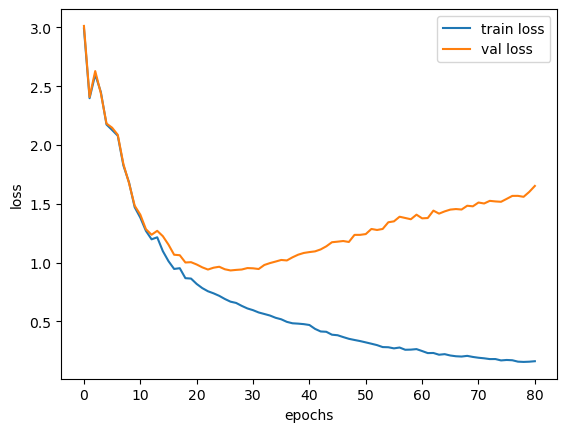

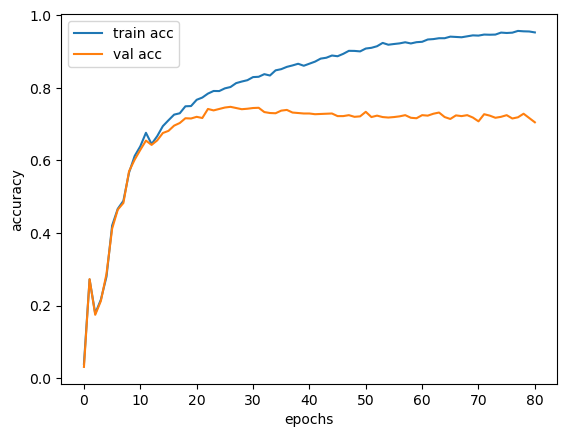

Best val acc: 0.748, best test acc: 0.723


In [13]:

# graphormer = Graphormer(real_feat_pca.shape[2], hidden_size, num_classes).to(device)
# best_val_acc, best_test_acc, best_embeddings_graphormer = train(g, graphormer, real_feat_pca, epochs=10)

Graphormer128_embeddings = train_graphormer_wrapper(Graphormer, feat, hidden_size, num_classes, g, traget_components=128, epochs=200)



#### another test on dimension 32

In epoch 0, loss: 3.082, val acc: 0.043 (best 0.043, best 0.041)
In epoch 10, loss: 1.693, val acc: 0.510 (best 0.510, best 0.512)
In epoch 20, loss: 1.240, val acc: 0.623 (best 0.623, best 0.610)
In epoch 30, loss: 1.088, val acc: 0.655 (best 0.655, best 0.645)
In epoch 40, loss: 1.017, val acc: 0.653 (best 0.662, best 0.649)
In epoch 50, loss: 0.943, val acc: 0.660 (best 0.667, best 0.648)
In epoch 60, loss: 0.891, val acc: 0.666 (best 0.667, best 0.648)
In epoch 70, loss: 0.839, val acc: 0.664 (best 0.673, best 0.662)
In epoch 80, loss: 0.802, val acc: 0.662 (best 0.677, best 0.664)
In epoch 90, loss: 0.756, val acc: 0.662 (best 0.677, best 0.664)
Early stopping at epoch 90


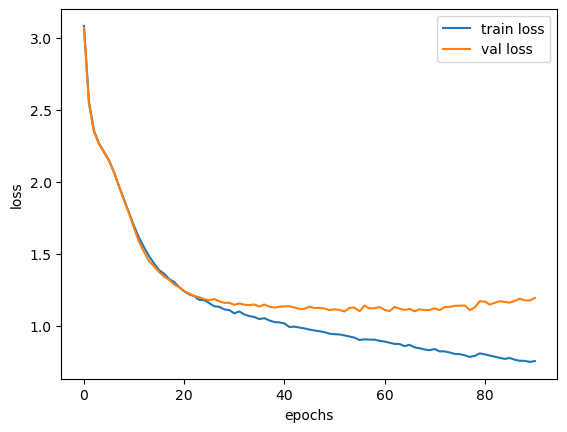

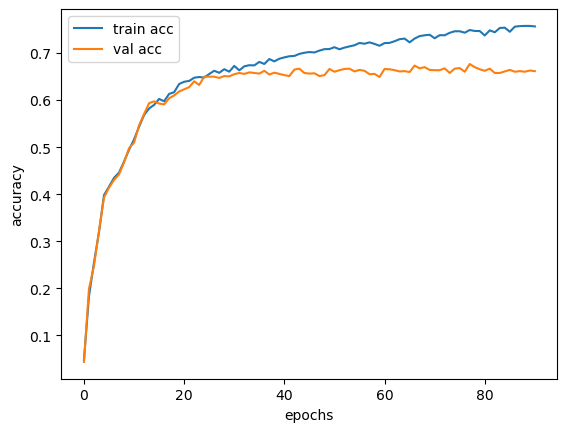

Best val acc: 0.677, best test acc: 0.664


In [14]:
Graphormer32_embeddings = train_graphormer_wrapper(Graphormer, feat, hidden_size, num_classes, g, traget_components=32, epochs=100)

## visualize the embedding features

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_embeddings(embeddings, labels):
  labels = labels.cpu()
  embeddings = embeddings.cpu().detach().numpy()
  tsne = TSNE().fit_transform(embeddings)
  plt.scatter(tsne[:, 0], tsne[:, 1], c=labels)


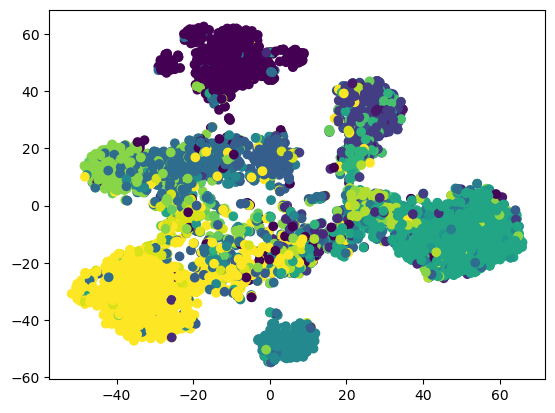

In [16]:
plot_embeddings(Graphormer128_embeddings, labels)

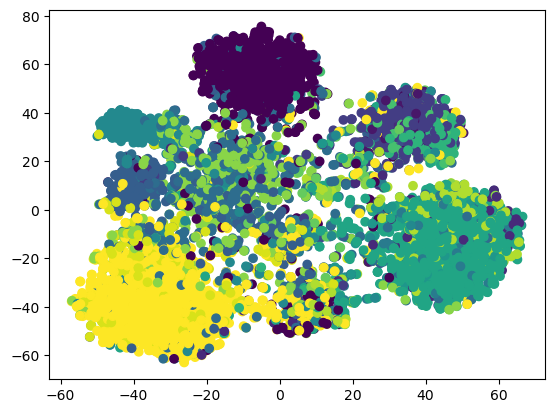

In [17]:
plot_embeddings(Graphormer32_embeddings, labels)